In [103]:
using Revise
using LinearAlgebra
using HierarchicalDA
using Distributions
using Statistics
using PDMats
using ProgressMeter
using KernelDensity
using QuadGK
using ApproxFun
using BenchmarkTools
using StaticArrays
using SpecialFunctions
using StatsFuns
using ForwardDiff
using Roots
using Integrals
using FiniteDiff

In [2]:
using CairoMakie
using LaTeXStrings

In [3]:
Nx = 1
Ny = 1

1

In [211]:
# power parameters
r_range = [ 1.0, .5, -.5, -1.0 ]; 
# shape parameters 
β_range = [ 1.501, 3.0918, 2.0165, 1.0017 ]; 
# rate parameters 
ϑ_range = [ 5*10^(-2), 5.9323*10^(-3), 1.2583*10^(-3), 1.2308*10^(-4) ]; 

In [213]:
idx = 3
r = r_range[idx]
ϑ = ϑ_range[idx]
β = β_range[idx]

2.0165

In [214]:
# Reference distribution
ηθ = Gamma(β, ϑ)

Gamma{Float64}(α=2.0165, θ=0.0012583)

In [215]:
πθ = GeneralizedGamma(r, β, ϑ)
πmultiθ = Product([πθ])

Product{Continuous, GeneralizedGamma{Float64}, Vector{GeneralizedGamma{Float64}}}(v=GeneralizedGamma{Float64}[GeneralizedGamma{Float64}(
r: -0.5
β: 2.0165
ϑ: 0.0012583
gamma_dist: Gamma{Float64}(α=2.0165, θ=1.0)
)
])

In [216]:
H = Diagonal(ones(Nx))
    
πZ = MvNormal(zeros(Nx), PDiagMat(ones(Nx)))
πϵ = MvNormal(zeros(Nx), (0.01)*PDiagMat(ones(Nx)))

DiagNormal(
dim: 1
μ: [0.0]
Σ: [0.01;;]
)


In [217]:
θstar = rand(πθ)
xstar = rand(Normal(0, sqrt(θstar)))
ϵstar = rand(πϵ)
ystar = (H*xstar + ϵstar)[1]

@show θstar, xstar, ϵstar, ystar

ystar = 5e-1

(θstar, xstar, ϵstar, ystar) = (0.0010343812118008397, 0.02054139477445424, [0.051529634840738685], 0.07207102961519293)


0.5

In [218]:
α = r*β - 0.5
κ = r
p = ϑ^r

q = xstar^2/2#rand(Normal())^2

Γstruct = ExtendedGamma(α, κ, p, q)

ExtendedGamma(α=-1.50825, κ=-0.5, p=28.19083253507958, q=[0.000210974449639988], Z=[34236.78499065367], cache=[34236.78499065367])

In [219]:
# Working with the multi-variate version fixes the ambiguity of providing the standard deviation in 1D 
# and the covariance in multi-dimensions.
# Build joint distribution πθXY = πθ πX|θ πY|X
function πθXY(θ, x, y)
    if typeof(θ)<:Real && typeof(x)<:Real && typeof(y) <: Real
        return pdf(πmultiθ, [θ])*pdf(MvNormal(zeros(Nx), PDiagMat([θ])), [x])*pdf(πϵ, [y] - H*[x])
    else
        return pdf(πmultiθ, θ)*pdf(MvNormal(zeros(Nx), PDiagMat(θ)), x)*pdf(πϵ, y - H*x)
    end
end

πθXY (generic function with 1 method)

In [220]:
function πθX(θ, x)
    if typeof(θ)<:Real && typeof(x)<:Real
        return pdf(πmultiθ, [θ])*pdf(MvNormal(zeros(Nx), PDiagMat([θ])), [x])
    else
        return pdf(πmultiθ, θ)*pdf(MvNormal(zeros(Nx), PDiagMat(θ)), x)
    end
end

πθX (generic function with 1 method)

In [221]:
πXY(x, y) = quadgk(θ -> πθXY(θ, x, y), 0, Inf; rtol = 1e-6)[1]
πY(y) = quadgk(x->πXY(x,y), -Inf, Inf; rtol = 1e-6)[1]
πθY(θ, y) = quadgk(x -> πθXY(θ, x, y), -Inf, Inf; rtol = 1e-6)[1]
πθgivenXY(θ, x, y) = πθXY(θ, x, y)/πXY(x, y)
πθgivenX(θ, x) = quadgk(y->πθXY(θ, x, y), -Inf, Inf; rtol = 1e-6)[1]/quadgk(y->πXY(x, y), -Inf, Inf; rtol = 1e-6)[1]

πXgivenθY(θ, x, y) = πθXY(θ, x, y)/πθY(θ, y)
πθXgivenY(θ, x, y) = πθXY(θ, x, y)/πY(y)

πθXgivenY (generic function with 1 method)

In [222]:
ΣXgivenθYinv(θ, y) = 1.0 ./ [θ] + H*inv(cov(πϵ))*H
# ΣXgivenθY(θ, y) = inv(ΣXgivenθYinv(θ, y))
ΣXgivenθY(θ, y) = reshape([θ] - [θ]*H'*inv(cov(πϵ)+ H*[θ]*H')*H*[θ], 1,1)


μXgivenθY(θ, y) = reshape(ΣXgivenθY(θ, y)*H'*inv(cov(πϵ))*y, 1)


μXgivenθY (generic function with 1 method)

In [223]:
μXgivenθY(θstar, ystar)

1-element Vector{Float64}:
 0.046870829997001075

In [236]:
?LinRange

search: LinRange log_integrand_extended_dist NormalInverseGaussian



```
LinRange{T,L}
```

A range with `len` linearly spaced elements between its `start` and `stop`. The size of the spacing is controlled by `len`, which must be an `Integer`.

# Examples

```jldoctest
julia> LinRange(1.5, 5.5, 9)
9-element LinRange{Float64, Int64}:
 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5
```

Compared to using [`range`](@ref), directly constructing a `LinRange` should have less overhead but won't try to correct for floating point errors:

```jldoctest
julia> collect(range(-0.1, 0.3, length=5))
5-element Vector{Float64}:
 -0.1
  0.0
  0.1
  0.2
  0.3

julia> collect(LinRange(-0.1, 0.3, 5))
5-element Vector{Float64}:
 -0.1
 -1.3877787807814457e-17
  0.09999999999999999
  0.19999999999999998
  0.3
```


In [224]:
πXgivenθY_true(θ, x, y) = pdf(MvNormal(μXgivenθY(θ, y), PDMat(ΣXgivenθY(θ, y))), [x])

πXgivenθY_true (generic function with 1 method)

In [225]:
θgrid = collect(0.0:0.001:0.2)[2:end]
xgrid = collect(-0.5:0.001:1.0);

In [226]:
πθgivenX_tab = zeros(length(θgrid))
@showprogress for (i, θi) in enumerate(θgrid)
    πθgivenX_tab[i] = πθgivenX(θi, xstar)
end
# map(θ -> πθgivenX(θ, xstar), θgrid)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


In [227]:
πθX_tab = zeros(length(θgrid), length(xgrid))
    
@showprogress for (i, θi) in enumerate(θgrid)
    for (j, xj) in enumerate(xgrid)
        πθX_tab[i,j] = πθX(θi, xj)
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [228]:
maximum(πθX_tab)

2571.902532820951

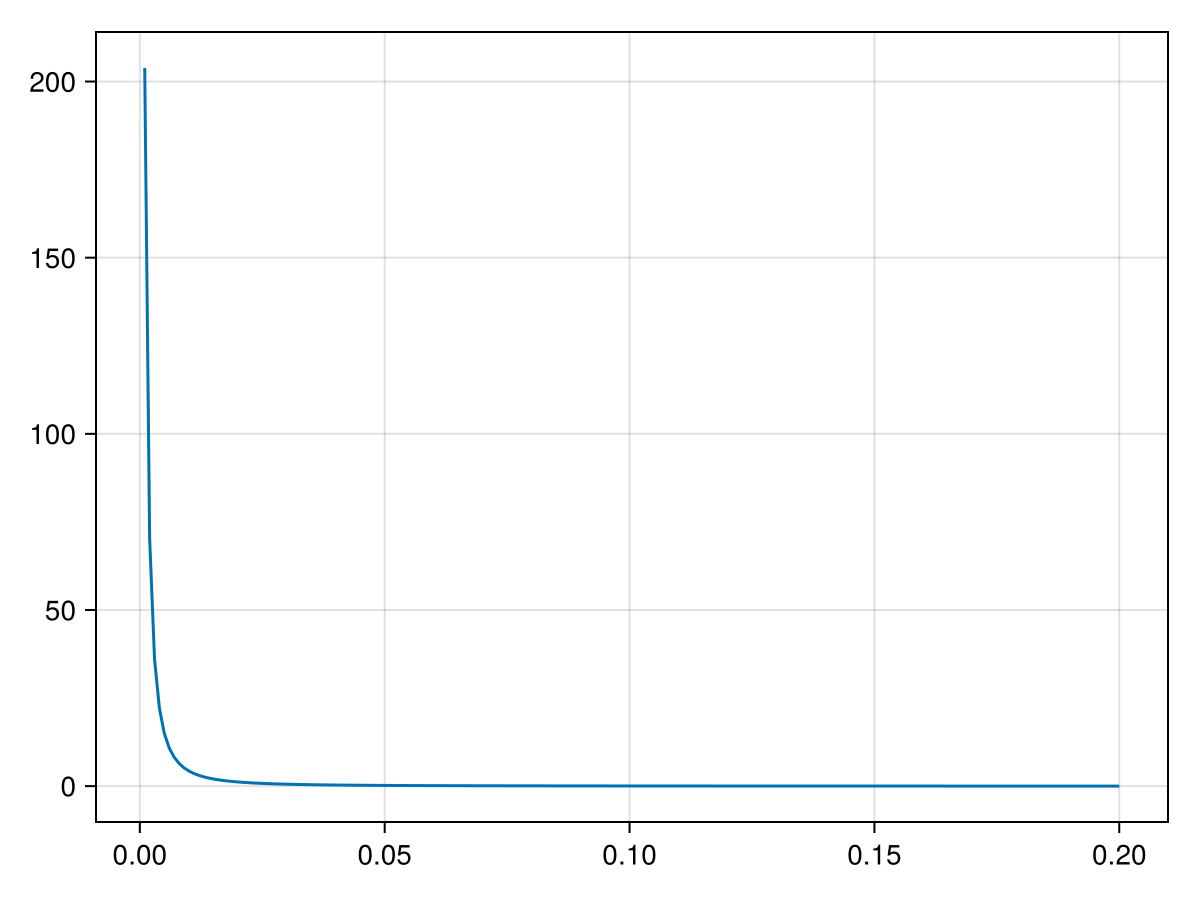

In [234]:
fig = Figure()

ax = Axis(fig[1,1])

lines!(ax, , θ -> pdf(πθ, θ))
    
fig

In [229]:
πθXgivenY_tab = zeros(length(θgrid), length(xgrid))
    
@showprogress for (i, θi) in enumerate(θgrid)
    for (j, xj) in enumerate(xgrid)
        πθXgivenY_tab[i,j] = πθXY(θi, xj, ystar)
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


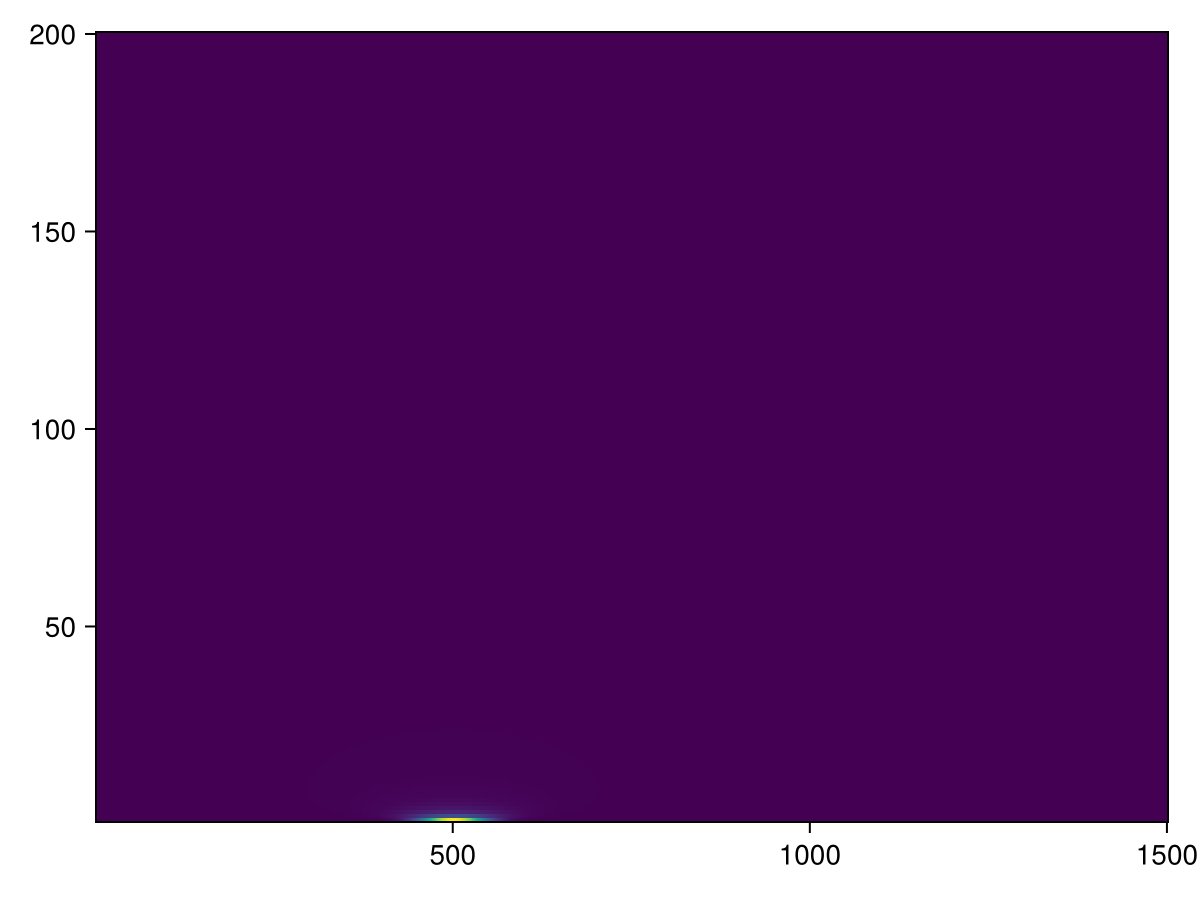

In [231]:
fig = Figure()

ax = Axis(fig[1,1])

heatmap!(ax, πθX_tab')
    
fig

In [171]:
πXgivenθY_tab = map(x -> πXgivenθY(θstar, x, ystar), xgrid)

1001-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

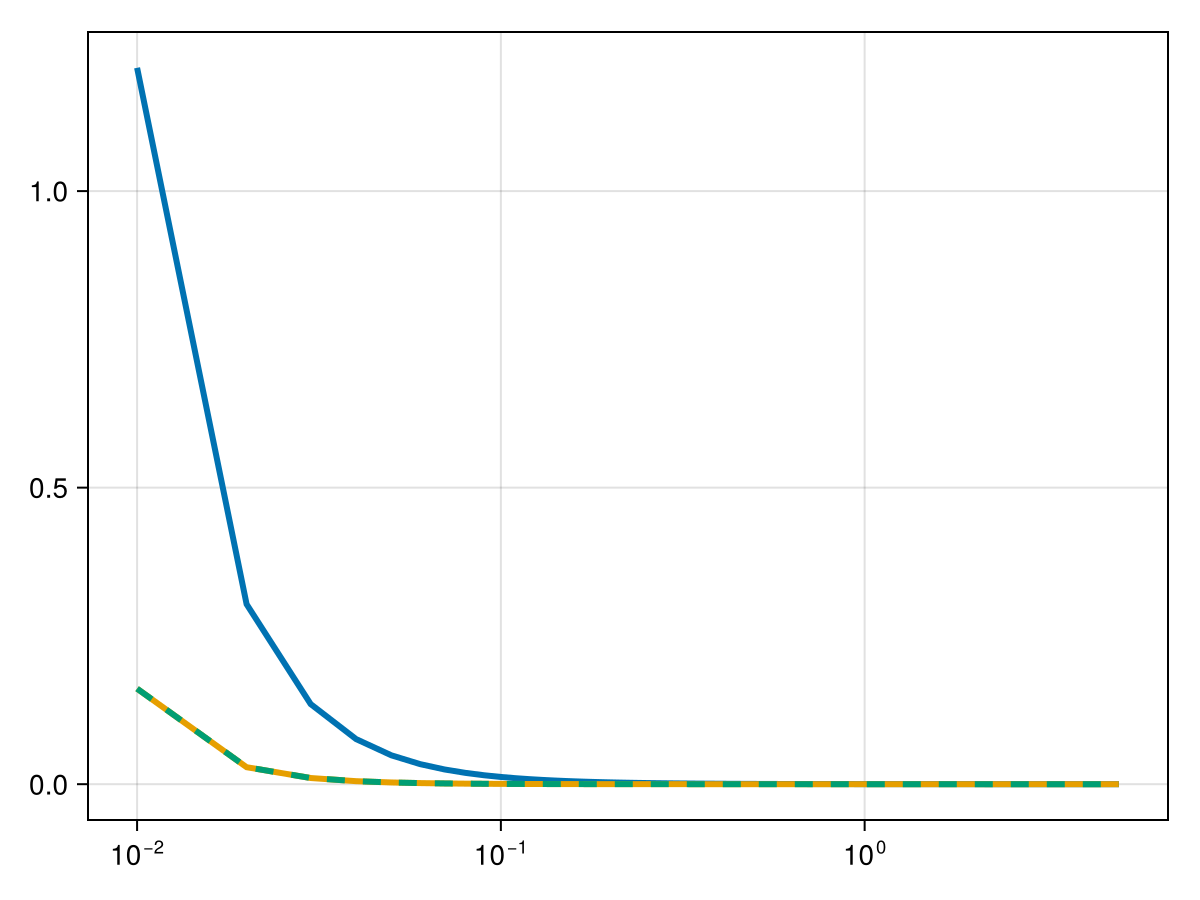

In [172]:
fig = Figure()

ax = Axis(fig[1,1], xscale = log10)

lines!(ax, θgrid, pdf.(πθ, θgrid), linewidth = 3)
lines!(ax, θgrid, πθgivenX_tab, linewidth = 3)
lines!(ax, θgrid, θ -> pdf(Γstruct, θ), linestyle = :dash, linewidth = 3)

    
fig

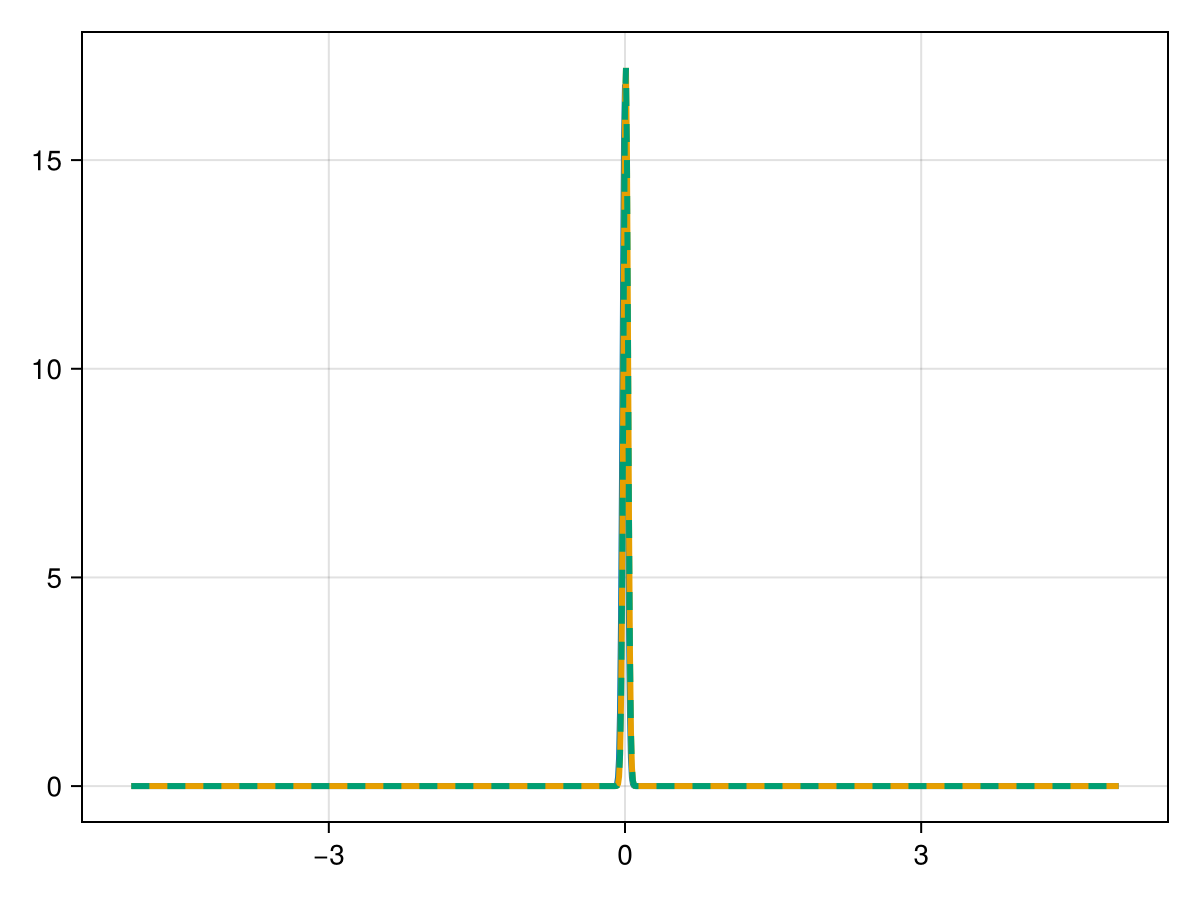

In [173]:
fig = Figure()

ax = Axis(fig[1,1])

lines!(ax, xgrid, x-> pdf(MvNormal(zeros(1), PDiagMat([θstar])), [x]), linewidth = 3)
lines!(ax, xgrid, πXgivenθY_tab, linewidth = 3)
lines!(ax, xgrid, x->πXgivenθY_true(θstar, x, ystar), linewidth = 3, linestyle = :dash)

# lines!(ax, θgrid, θ -> pdf(struct, θ), linestyle = :dash, linewidth = 3)

    
fig

In [174]:
function Sθ(dist::ExtendedGamma, η, x, θ, count; isupdate_Z = true)
    count .+= 1
    if isupdate_Z == true
        dist.q .= dot(x,x)/2
        update_Znorm!(dist)
    end
    cdf!(dist.cache, dist, θ)
    if typeof(η) <:Gamma
        Distributions.quantile(η, clamp(abs(dist.cache[1]), eps(), 1.0))
    else
        Distributions.quantile(η, clamp(abs(dist.cache[1]), eps(), 1.0))
    end
end

Sθ (generic function with 2 methods)

In [175]:
function Sθ_AD(dist::ExtendedGamma, η, x, θ)
#     dist.q .= dot(x,x)/2
#     update_Znorm!(dist)
    
    domainθ = (zero(eltype(θ)), θ)
    probθ = IntegralProblem((u,p) -> integrand_extended_dist(dist, u), domainθ, ones(1))
    
#     domain_inf = (0.0, Inf)
#     prob_inf = IntegralProblem((u,p) -> integrand_extended_dist(dist, u), domain_inf, ones(1))
    
    cdf_AD = solve(probθ, HCubatureJL(), reltol = 1e-6, abstol = 1e-6)[1]
#     return cdf_AD
#     cdf_AD /= Znorm(dist)
    return Distributions.quantile(η, abs(cdf_AD))
end

Sθ_AD (generic function with 1 method)

In [176]:
# We look for the θ value such that Sθ(x, θ) = z
function Sθinv(dist::ExtendedGamma, η, x, z; isupdate_Z = true)
    count = [0]
    θa = Roots.find_zero(θ -> Sθ(dist, η, x, θ, view(count, 1); isupdate_Z = true) - z, (eps(), 100))
    
    @assert isapprox(Sθ(dist, η, x, θa), z, atol = 1e-10)
#     @show count
    return θa
end

Sθinv (generic function with 1 method)

In [177]:
z = rand(ηθ)

7.307485272675749e-5

In [178]:
# # @btime begin 
#     f = Fun(t->integrand_extended_dist(Γstruct, t), Interval(0.0, Inf))
#     ∫f = cumsum(f)
    
# #     ∫f(θ)/∫
#     Roots.find_zero(θ -> quantile(ηθ, abs(∫f(θ)/∫f(Inf))) - z, (eps(), 100))
# # end

In [179]:
Ne = 10000
θsample = zeros(Ne)

@showprogress for i=1:Ne
    zi = rand(ηθ)
    θsample[i] = Sθinv(Γstruct, ηθ, xstar, zi; isupdate_Z= false)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


In [180]:
function Sθpullback(dist::ExtendedGamma, η, x, θ)
    # We want a right directed scheme
    det∇Sθ = FiniteDiff.finite_difference_derivative(t -> Sθ(dist, η, x, t), θ)
    return pdf(η, Sθ(dist, η, x, θ))*det∇Sθ
end

Sθpullback (generic function with 1 method)

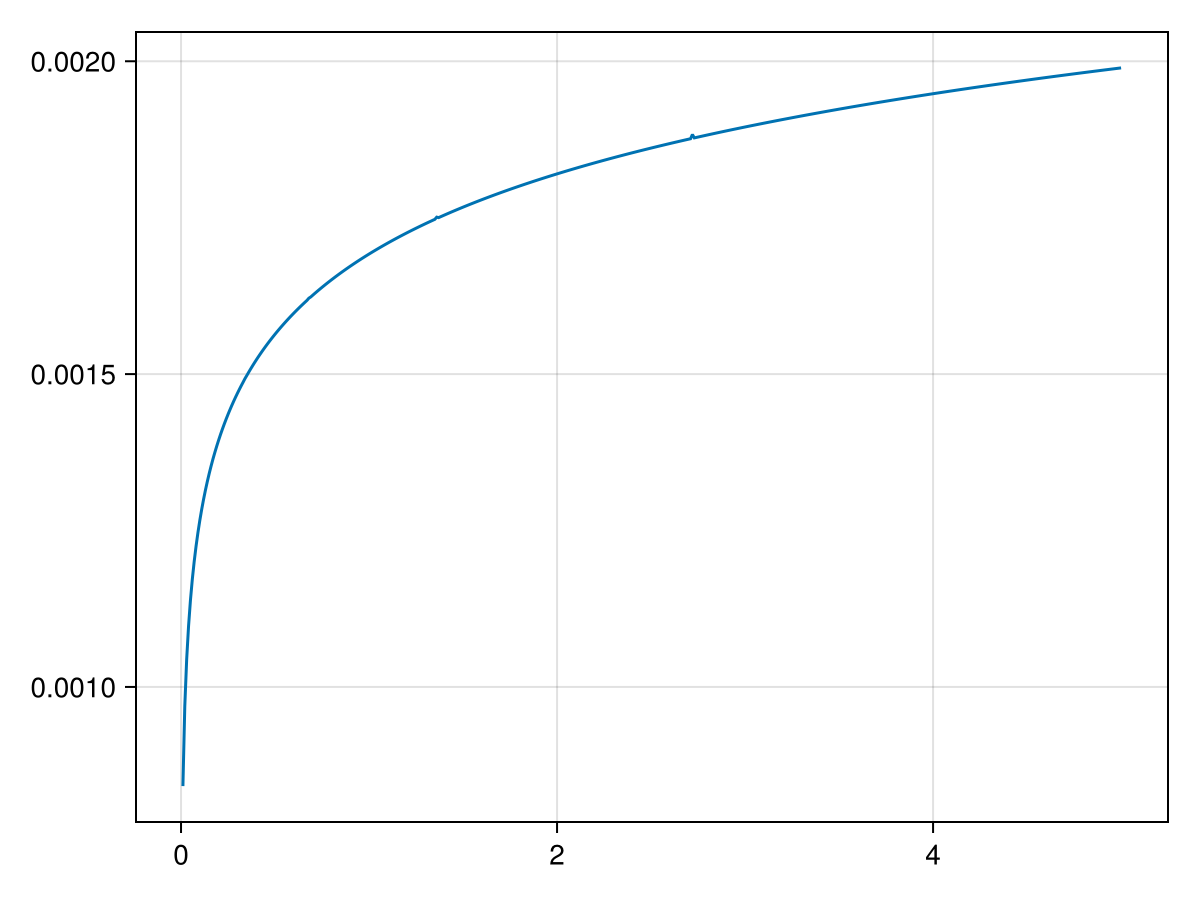

In [181]:
fig = Figure()

ax = Axis(fig[1,1])

lines!(ax, θgrid, θ -> Sθ(Γstruct, ηθ, xstar, θ))
    
fig

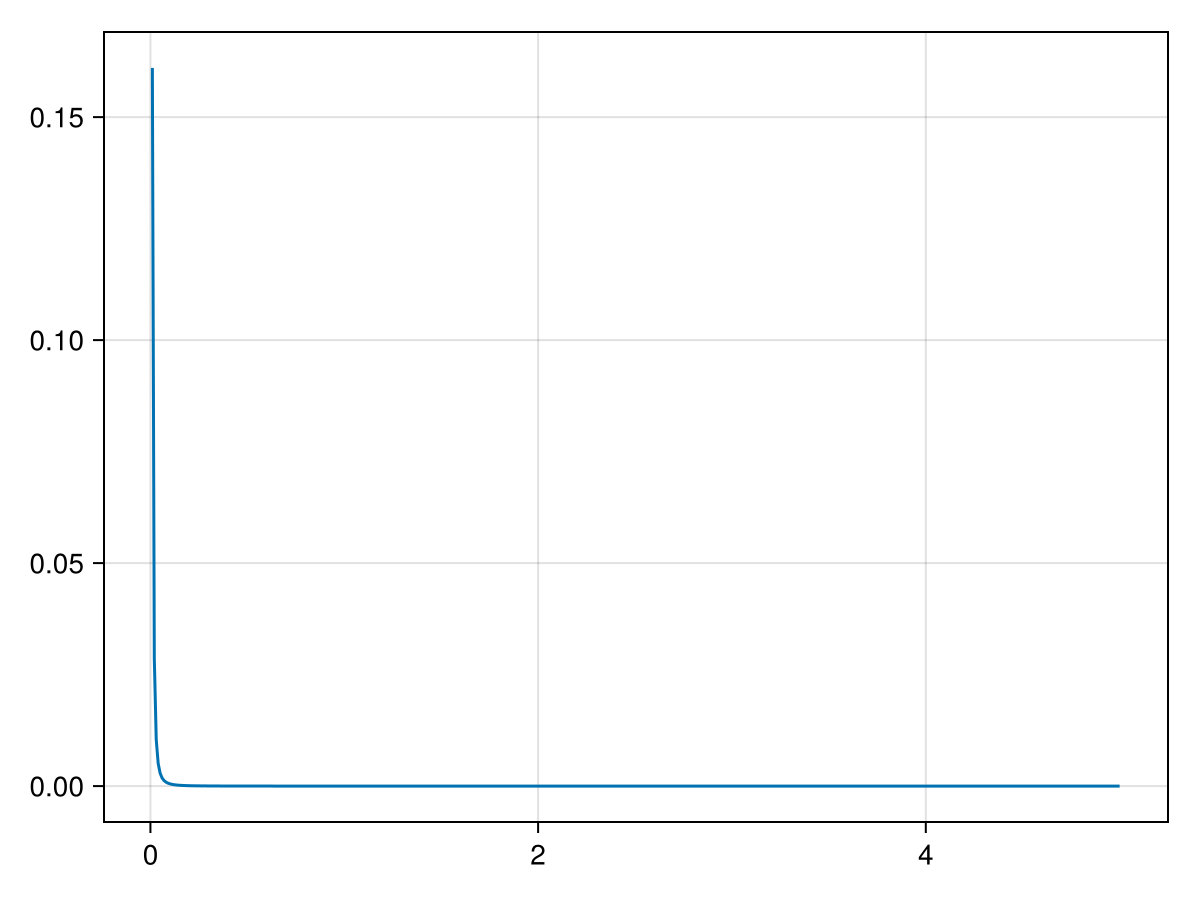

In [182]:
fig = Figure()

ax = Axis(fig[1,1])

lines!(ax, θgrid, θ -> Sθpullback(Γstruct, ηθ, xstar, θ))
# lines!(ax, θgrid, θ -> pdf(Γstruct, θ), linestyle = :dash)
# hist!(ax, θsample; normalization = :pdf, bins = 1000)
fig

In [183]:
# θsamples
θXY = zeros(3, Ne)

for i=1:Ne
    θi = rand(πθ)
    θXY[1,i] = θi
    xi = rand(Normal(0, sqrt(θi)))
    θXY[2,i] = xi
    ϵi = rand(πϵ)
    yi = H*xi + ϵi
    θXY[3,i] = yi[1]
end

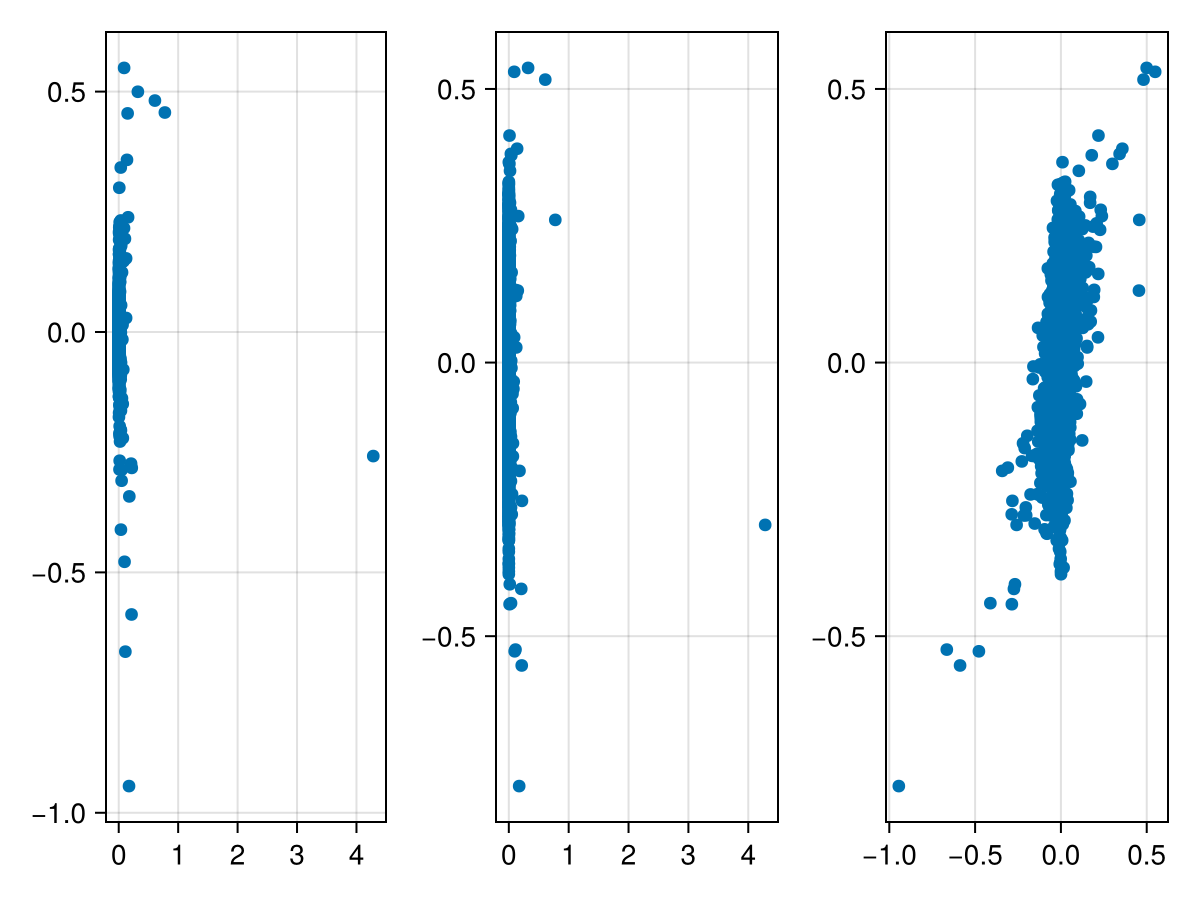

In [184]:
fig = Figure()

ax1 = Axis(fig[1,1])

scatter!(ax1, θXY[1:2,:])

ax2 = Axis(fig[1,2])

scatter!(ax2, θXY[[1;3],:])

ax3 = Axis(fig[1,3])

scatter!(ax3, θXY[[2;3],:])

fig